In [1]:
# Extensions for code formatting and inline plotting
%load_ext nb_black
#%matplotlib inline

<IPython.core.display.Javascript object>

In [2]:
# Library importing
import pandas as pd
import numpy as np
import seaborn as sns
import math
import warnings
import os
import matplotlib.pyplot as plt
import pmdarima as pm
from prophet import Prophet

warnings.filterwarnings("ignore")  # Ignoring warnings to reduce text spam.

# Preferences
sns.set(rc={"figure.figsize": (15, 8.27)})
pd.set_option("display.float_format", "{:,}".format)
pd.set_option("display.max_columns", 30)
pd.set_option("display.max_rows", None)

C:\Users\clawl\final_project\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<IPython.core.display.Javascript object>

In [3]:
# Data retrieval function
def retrieve_data():
    os.chdir('..')
    cwd = os.getcwd()
    if 'data' in os.listdir():
        os.chdir(cwd + '\\data')
        df = pd.read_csv('data.csv', sep=';', decimal=',')
        df['ds'] = pd.to_datetime(df[['year','month']].assign(day=1))
        df['y'] = df['quantity'].round().astype('int64')
        df.drop(columns=['year','month','quantity'], inplace=True)
        return df

<IPython.core.display.Javascript object>

In [5]:
# data object
df = retrieve_data()

<IPython.core.display.Javascript object>

In [6]:
df.head(20)

,ds,y
0,2010-01-01,10205914
1,2010-02-01,10390060
2,2010-03-01,12392784
3,2010-04-01,10876033
4,2010-05-01,12035571
5,2010-06-01,10134094
6,2010-07-01,9561953
7,2010-08-01,9845679
8,2010-09-01,12236500
9,2010-10-01,10949143


<IPython.core.display.Javascript object>

[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'quantity'),
 Text(0.5, 1.0, 'Medicine sales over time')]

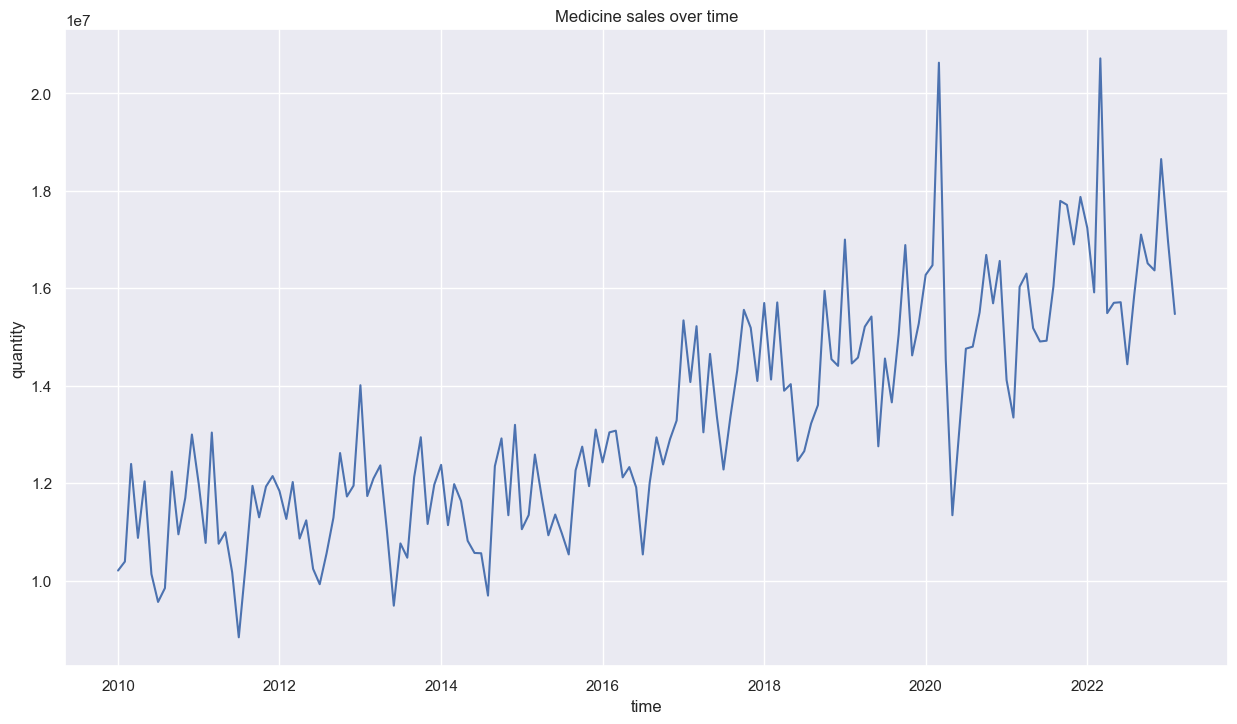

<IPython.core.display.Javascript object>

In [7]:
fig = sns.lineplot(df, x='ds', y='y')
fig.set(xlabel='time', ylabel='quantity', title='Medicine sales over time')

In [14]:
model = Prophet(
    seasonality_mode='multiplicative',
    yearly_seasonality=True,
    daily_seasonality=False,
    weekly_seasonality=False,
    interval_width=0.3,
    changepoint_range=0.7,
    changepoint_prior_scale=0.5,
   # seasonality_prior_scale=2,
)
#model.add_country_holidays(country_name="LT")
model.fit(df)
future = model.make_future_dataframe(periods=60, freq='MS', include_history=True)
forecast = model.predict(future)

19:36:04 - cmdstanpy - INFO - Chain [1] start processing
19:36:04 - cmdstanpy - INFO - Chain [1] done processing


<IPython.core.display.Javascript object>

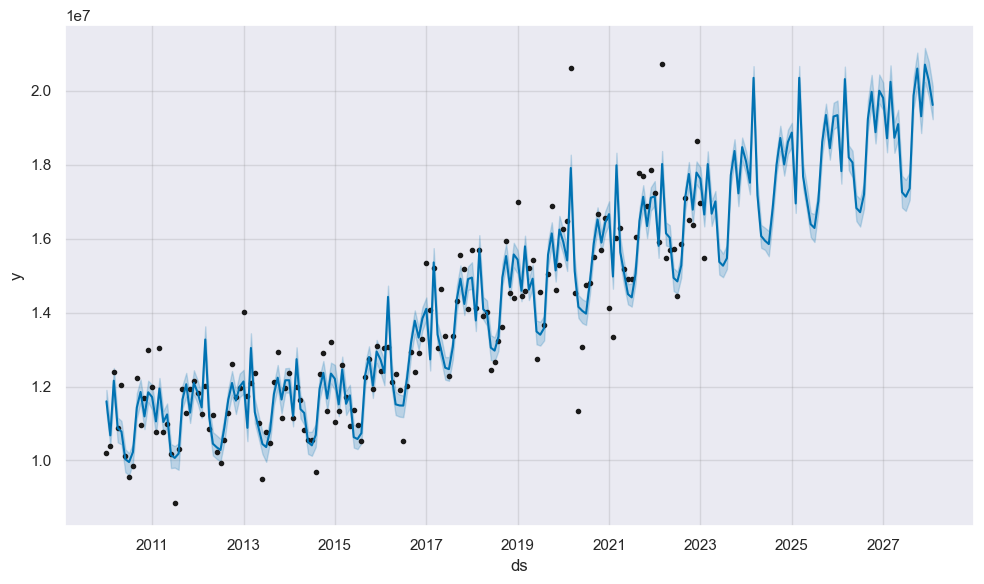

<IPython.core.display.Javascript object>

In [25]:
a = model.plot(forecast)

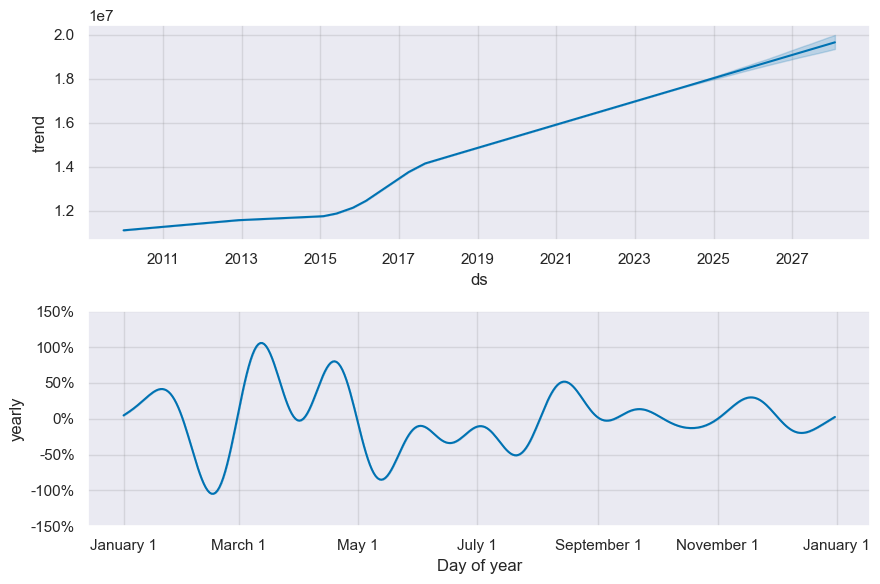

<IPython.core.display.Javascript object>

In [20]:
plt = model.plot_components(forecast)

In [21]:
def fit_predict_model(dataframe, interval_width = 0.99, changepoint_range = 0.8):
    m = Prophet(daily_seasonality = False, yearly_seasonality = True, weekly_seasonality = False,
               seasonality_mode = 'multiplicative',
               interval_width = interval_width,
               changepoint_range = changepoint_range)
    m = m.fit(dataframe)
    future = m.make_future_dataframe(periods=60, freq='MS', include_history=True) 
    forecast = m.predict(future)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    return forecast, m

<IPython.core.display.Javascript object>

In [23]:
pred, model = fit_predict_model(df, 0.8, 0.99)

19:36:58 - cmdstanpy - INFO - Chain [1] start processing
19:36:58 - cmdstanpy - INFO - Chain [1] done processing


<IPython.core.display.Javascript object>

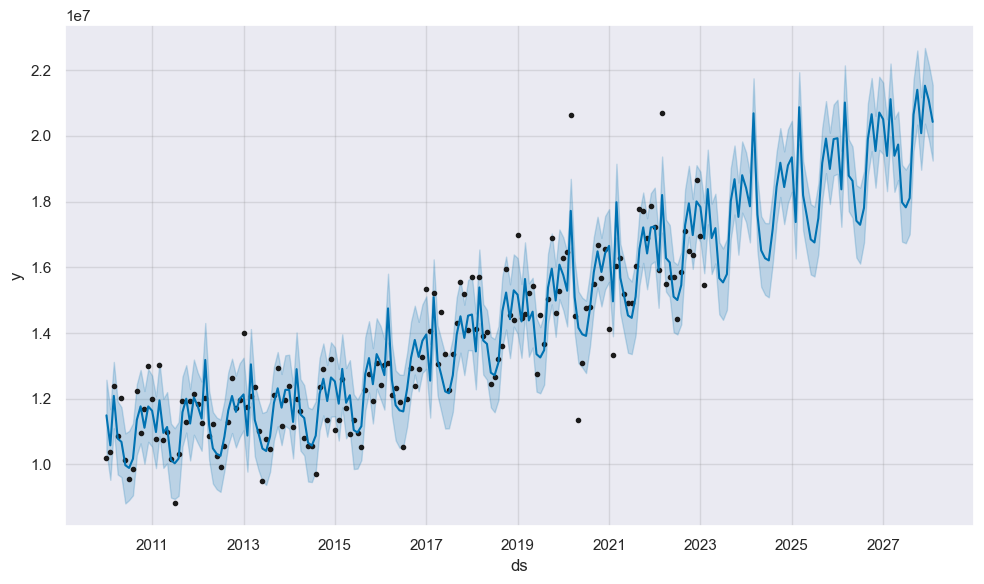

<IPython.core.display.Javascript object>

In [27]:
f = model.plot(pred)

In [28]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1
#anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']

    return forecasted

<IPython.core.display.Javascript object>

In [29]:
pred = detect_anomalies(pred)

<IPython.core.display.Javascript object>

In [30]:
pred[pred['anomaly'] != 0]

,ds,trend,yhat,yhat_lower,yhat_upper,fact,anomaly,importance
0,2010-01-01,"11,024,182.134698","11,492,141.027624246","10,396,260.159368455","12,576,056.240057055","10,205,914.0",-1,0.01865057449714503
4,2010-05-01,"11,085,275.846847706","10,684,107.49311752","9,608,274.580258837","11,741,085.069578608","12,035,571.0",1,0.024467965036423407
11,2010-12-01,"11,194,226.299351899","11,764,354.027862202","10,685,390.850599358","12,897,835.600893093","12,996,323.0",1,0.007578097213104562
18,2011-07-01,"11,302,158.528980078","10,032,235.412905898","8,945,041.551821789","11,100,551.39111869","8,836,242.0",-1,0.012312875973947836
26,2012-03-01,"11,426,382.41075245","13,180,006.02180405","12,155,418.75589645","14,304,434.626661427","12,021,802.0",-1,0.011114536397825309
36,2013-01-01,"11,582,171.392744647","12,129,320.454909064","11,036,966.96565595","13,247,295.141329","14,008,014.0",1,0.054305975041929584
55,2014-08-01,"11,902,610.460313728","10,874,482.20200944","9,787,837.491266973","11,917,189.707765587","9,692,112.0",-1,0.009876638989208267
60,2015-01-01,"12,071,339.59716273","12,526,565.564920682","11,467,336.225366235","13,565,900.287991473","11,053,911.0",-1,0.03740081002698817
64,2015-05-01,"12,250,137.7639097","12,105,584.929985324","10,985,252.817621708","13,173,688.590183415","10,929,673.0",-1,0.005085222368657133
74,2016-03-01,"12,787,479.540493106","14,749,992.717624264","13,708,587.007229794","15,806,211.8722986","13,075,588.0",-1,0.04841074888791187


<IPython.core.display.Javascript object>

RMSE is the square root of MSE.<br>
MSE is measured in units that are the square of the target variable, while RMSE is measured in the same units as the target variable.<br>
Due to its formulation, MSE, just like the squared loss function that it derives from, effectively penalizes larger errors more severely.

In [76]:
from prophet.diagnostics import cross_validation
cutoffs = pd.date_range(start='2018-01-01', end='2022-12-01', freq='2MS')

df_cv = cross_validation(
    model, 
    initial='731 days', 
    horizon='365 days',
    period='365 days',
    #cutoffs = cutoffs,
    parallel = 'processes'
)

INFO:prophet:Making 11 forecasts with cutoffs between 2012-02-04 00:00:00 and 2022-02-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001C4207BB310>


<IPython.core.display.Javascript object>

In [77]:
df_cv[['ds','yhat','y','cutoff']]

,ds,yhat,y,cutoff
0,2012-03-01,"12,007,813.392546922",12021802,2012-02-04
1,2012-04-01,"11,145,809.684350755",10862213,2012-02-04
2,2012-05-01,"13,662,250.72295567",11235651,2012-02-04
3,2012-06-01,"9,167,891.67900805",10240797,2012-02-04
4,2012-07-01,"10,404,353.079729186",9925310,2012-02-04
5,2012-08-01,"8,564,354.346745607",10559250,2012-02-04
6,2012-09-01,"12,842,068.893702252",11290617,2012-02-04
7,2012-10-01,"10,585,581.695408298",12616500,2012-02-04
8,2012-11-01,"11,798,305.400428528",11725051,2012-02-04
9,2012-12-01,"15,519,996.758324724",11947712,2012-02-04


<IPython.core.display.Javascript object>

In [80]:
from prophet.diagnostics import performance_metrics

df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,57 days,"2,756,236,244,711.951","1,660,191.6289127443","1,207,568.7111653646",0.07459061518973163,0.07985597440993364,0.0759811030805533,0.38461538461538464
1,58 days,"2,439,195,958,435.6455","1,561,792.5465424804","1,032,026.8023003114",0.061577050580007606,0.041453980754498125,0.06337953077956894,0.5384615384615384
2,59 days,"1,653,720,311,840.208","1,285,970.5719184277","841,826.6752508224",0.05165074736624774,0.041453980754498125,0.05286075511404441,0.6923076923076923
3,87 days,"869,245,646,626.5963","932,333.441761367","719,303.8081577569",0.05803638677949609,0.04444293668229635,0.05562836334238467,0.6923076923076923
4,88 days,"1,138,202,205,044.847","1,066,865.5983978708","879,157.536948608",0.06816477679211554,0.052520627834436256,0.0663779404885115,0.6923076923076923
5,89 days,"2,597,422,463,127.332","1,611,652.0912179935","1,163,321.154495285",0.0942262077992578,0.052520627834436256,0.08757437646320494,0.6153846153846154
6,118 days,"2,422,065,954,937.815","1,556,298.800018112","1,087,689.8296529897",0.0925854600468022,0.07102702732242691,0.08729571511946813,0.5
7,119 days,"2,494,766,510,168.5557","1,579,482.9882491787","1,171,964.555156128",0.09854434474959232,0.09434693169908943,0.09467495339550511,0.34615384615384615
8,120 days,"2,032,281,466,467.1157","1,425,581.0978219078","1,113,903.3437157029",0.09285543423656348,0.09434693169908943,0.0899663118400702,0.3333333333333333
9,148 days,"1,082,322,559,599.6206","1,040,347.326424988","960,496.4749160123",0.08021688145114238,0.09434693169908943,0.08129460543381618,0.2692307692307692


<IPython.core.display.Javascript object>

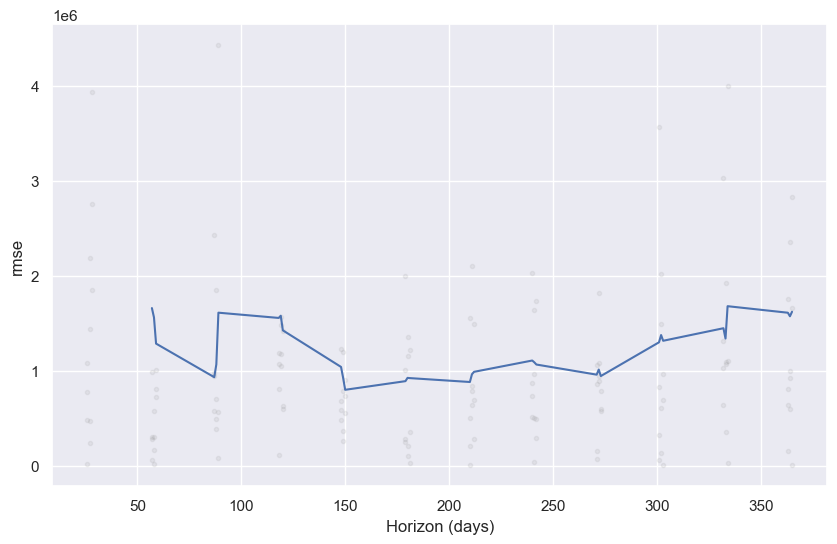

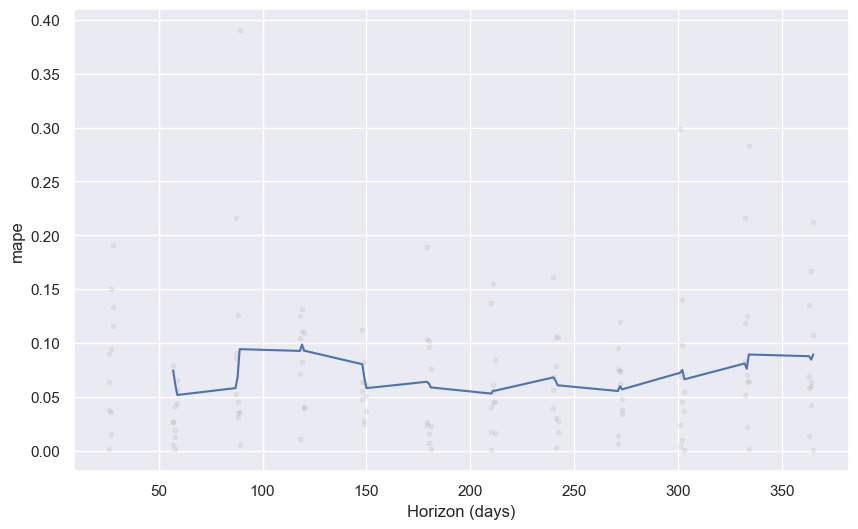

<IPython.core.display.Javascript object>

In [83]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')
fig = plot_cross_validation_metric(df_cv, metric='mape')


The mean absolute percentage error (MAPE) is the sum of the individual absolute forecast errors, divided by the actual values for each period.
It's an accuracy measure based on the relative percentage of errors.
The closer the MAPE value is to zero, the better the predictions.

In [87]:
# Relative percentage error
df_p['mape'].mean()

0.07072524539450177

<IPython.core.display.Javascript object>